In [ ]:
rm -rf /root/.keras/datasets

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib

dataset_url = "https://dl.dropboxusercontent.com/scl/fi/7lvh7z53wewiyluzux7do/images.zip?rlkey=xiarynvedrs35w3ti7n7ygylf&dl=0"

In [ ]:
data_dir = tf.keras.utils.get_file('images.zip', origin=dataset_url, extract=True)
print(data_dir)

27052942/27052942 [==============================] - 0s 0us/step
/root/.keras/datasets/images.zip


In [ ]:
data_dir = pathlib.Path(data_dir).with_suffix('')
print(data_dir)

/root/.keras/datasets/images


In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(data_dir)
print(image_count)

/root/.keras/datasets/images
0


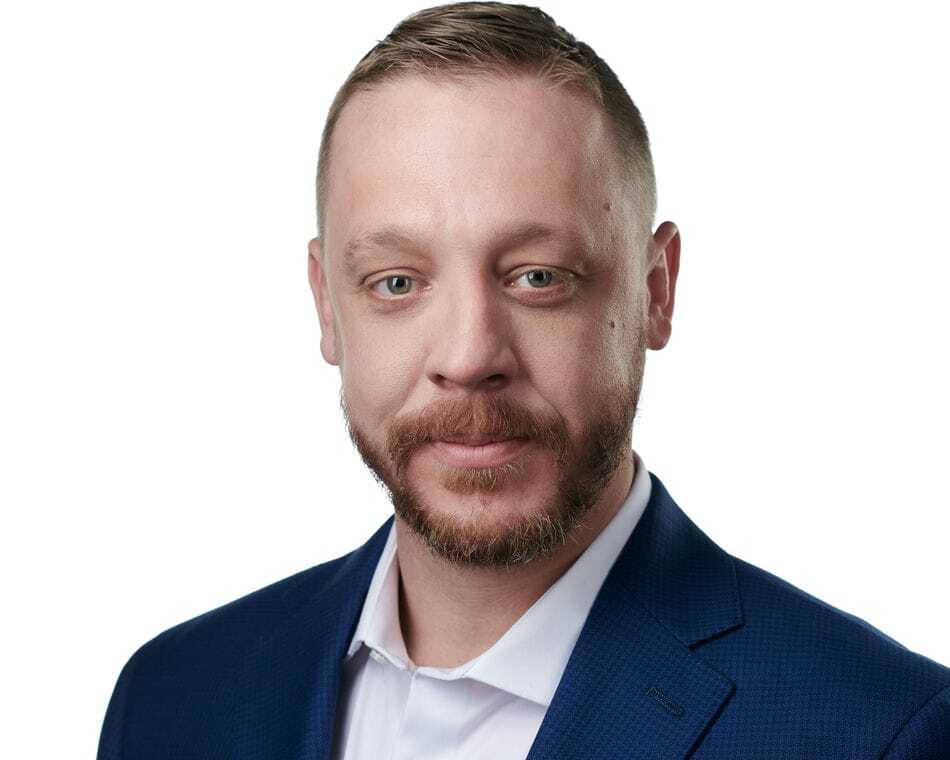

In [ ]:
hats = list(data_dir.glob('head/*'))
PIL.Image.open(str(hats[6]))

In [ ]:
batch_size = 32
img_height = 600
img_width = 600

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 400 files belonging to 2 classes.
Using 320 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 400 files belonging to 2 classes.
Using 80 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['hat', 'head']


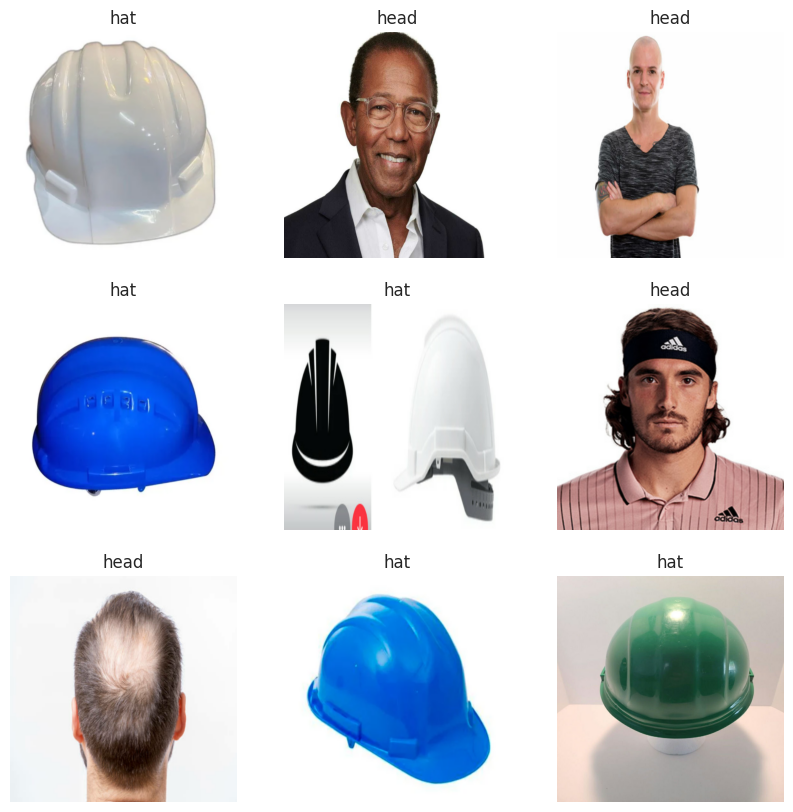

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 600, 600, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.00016552396 1.0


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 600, 600, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 600, 600, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 300, 300, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 300, 300, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 150, 150, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 150, 150, 64)     

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
10/10 [==============================] - 121s 12s/step - loss: 9.1568 - accuracy: 0.5594 - val_loss: 0.8336 - val_accuracy: 0.7500
Epoch 2/10
10/10 [==============================] - 120s 12s/step - loss: 0.4490 - accuracy: 0.8156 - val_loss: 0.2151 - val_accuracy: 0.9125
Epoch 3/10
10/10 [==============================] - 115s 12s/step - loss: 0.3143 - accuracy: 0.8281 - val_loss: 0.1965 - val_accuracy: 0.9250
Epoch 4/10
10/10 [==============================] - 118s 12s/step - loss: 0.1858 - accuracy: 0.9094 - val_loss: 0.1707 - val_accuracy: 0.9125
Epoch 5/10
10/10 [==============================] - 117s 12s/step - loss: 0.1347 - accuracy: 0.9406 - val_loss: 0.1317 - val_accuracy: 0.9375
Epoch 6/10
10/10 [==============================] - 118s 12s/step - loss: 0.0966 - accuracy: 0.9656 - val_loss: 0.1686 - val_accuracy: 0.9125
Epoch 7/10
10/10 [==============================] - 117s 12s/step - loss: 0.0465 - accuracy: 0.9906 - val_loss: 0.1367 - val_accuracy: 0.9750
Epoch 

3/3 [==============================] - 7s 2s/step


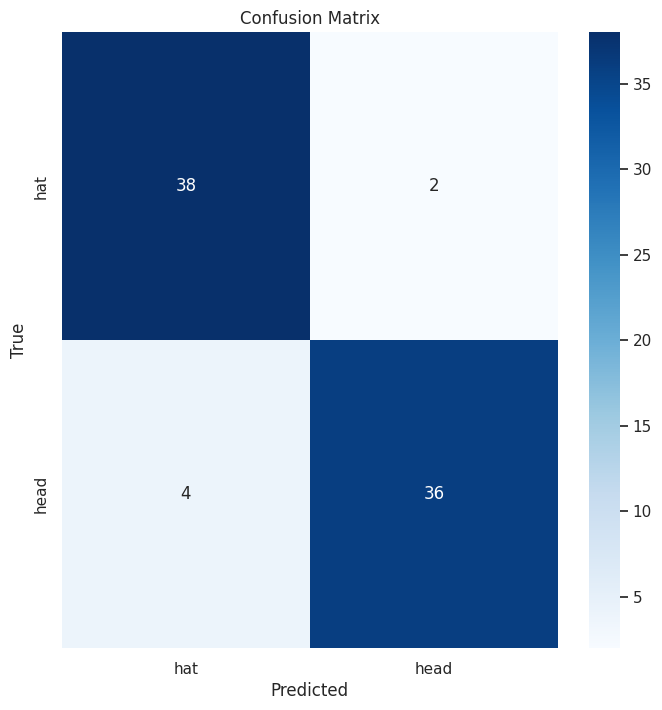

              precision    recall  f1-score   support

         hat       0.90      0.95      0.93        40
        head       0.95      0.90      0.92        40

    accuracy                           0.93        80
   macro avg       0.93      0.93      0.92        80
weighted avg       0.93      0.93      0.92        80



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(val_ds)

# Get predicted labels for the validation dataset
y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1)

# Get true labels for the validation dataset
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Create confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print(classification_report(y_true, y_pred, target_names=class_names))

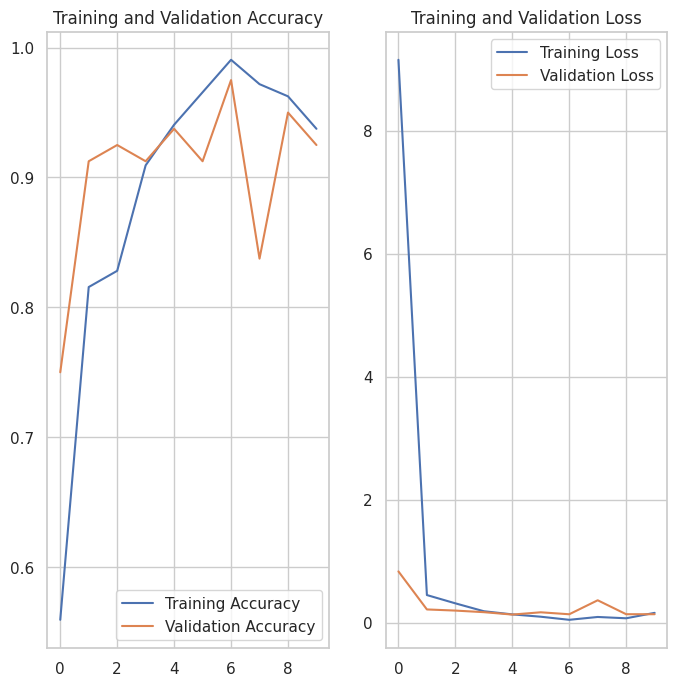

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

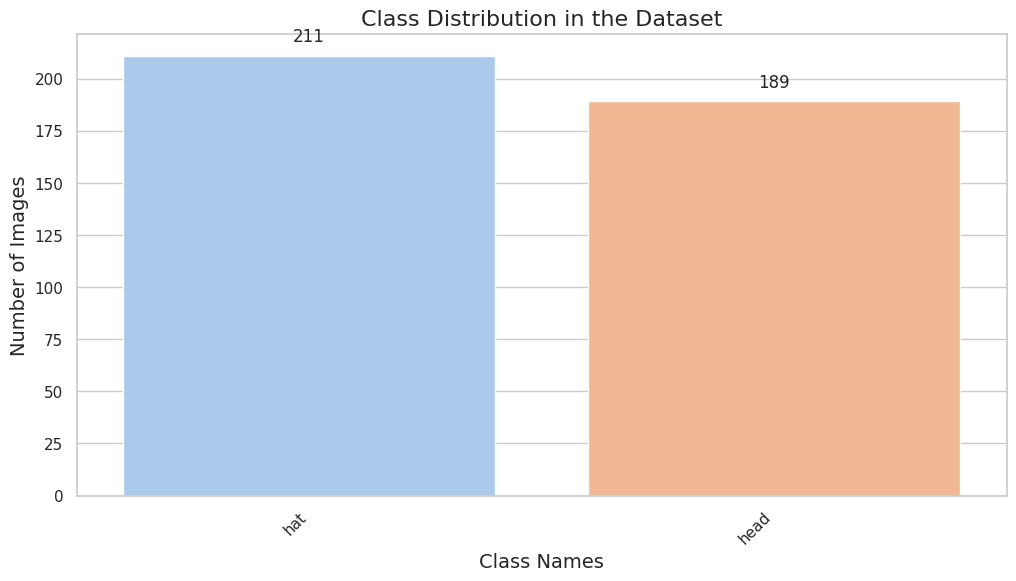

In [ ]:
# Class Distribution Plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
colors = sns.color_palette("pastel", n_colors=len(class_names))
class_counts = [len(list(data_dir.glob(f'{class_name}/*'))) for class_name in class_names]

# Create a bar plot with custom colors
ax = sns.barplot(x=class_names, y=class_counts, palette=colors)

# Add annotations
for i, count in enumerate(class_counts):
    ax.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=12)

plt.title('Class Distribution in the Dataset', fontsize=16)
plt.xlabel('Class Names', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
sunflower_url = "https://www.shutterstock.com/shutterstock/photos/2340822327/display_1500/stock-photo-asian-woman-worker-wearing-protective-mask-working-at-logistic-cargo-warehouse-export-and-import-2340822327.jpg"
sunflower_path = tf.keras.utils.get_file('img10000.jpg', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 105ms/step
This image most likely belongs to head with a 99.91 percent confidence.
